# Analyse Exploratoire

### Import des modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

### Analyse Exploratoire

In [3]:
building_consumption = pd.read_csv('../data/2016_Building_Energy_Benchmarking.csv')

In [4]:
# On regarde comment un batiment est défini dans ce jeu de données 
building_consumption.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,...,Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,...,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,...,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,...,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,...,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,...,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [5]:
# On regarde le nombre de valeurs manquantes par colonne ainsi que leur type 
building_consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

In [7]:
# On regarde les valeurs dans Building Type
building_consumption['BuildingType'].value_counts()

BuildingType
NonResidential          1460
Multifamily LR (1-4)    1018
Multifamily MR (5-9)     580
Multifamily HR (10+)     110
SPS-District K-12         98
Nonresidential COS        85
Campus                    24
Nonresidential WA          1
Name: count, dtype: int64

In [8]:
# On conserve uniquement les batiments BuildingType qui sont NonResidential, SPS-District K-12, Nonresidential COS et Nonresidential WA
building_consumption = building_consumption[building_consumption['BuildingType'].isin(['NonResidential', 'SPS-District K-12', 'Nonresidential COS', 'Nonresidential WA'])]

In [9]:
building_consumption.shape

(1644, 46)

In [15]:
building_consumption['PrimaryPropertyType'].value_counts()

PrimaryPropertyType
Small- and Mid-Sized Office    292
Other                          243
Warehouse                      187
Large Office                   172
K-12 School                    135
Mixed Use Property             110
Retail Store                    91
Hotel                           76
Worship Facility                71
Distribution Center             53
Supermarket / Grocery Store     40
Medical Office                  39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      18
Refrigerated Warehouse          12
Restaurant                      11
Hospital                        10
Laboratory                      10
Office                           3
Low-Rise Multifamily             2
Name: count, dtype: int64

In [10]:
# On regarde les statistiques descriptives des variables numériques
building_consumption.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,...,SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,1644.000000,1644.0,1628.000000,1644.000000,1644.000000,1644.000000,1644.000000,1642.000000,1644.000000,1.644000e+03,...,1.642000e+03,1.641000e+03,1.642000e+03,1.642000e+03,1.642000e+03,1.642000e+03,1.642000e+03,0.0,1642.000000,1642.000000
mean,16314.106448,2016.0,98116.876536,4.361922,47.616246,-122.332957,1961.925791,1.034105,4.144769,1.106277e+05,...,7.373224e+06,7.492230e+06,4.655966e+05,1.528241e+06,5.214360e+06,1.660929e+04,1.660929e+06,NaN,160.501760,1.570402
std,13824.494495,0.0,18.492115,2.188563,0.048141,0.024615,32.695137,0.552039,6.603893,1.865990e+05,...,1.814333e+07,1.830007e+07,5.146583e+06,3.717491e+06,1.268408e+07,5.352787e+04,5.352787e+06,NaN,554.183554,2.186648
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.411820,1900.000000,0.000000,0.000000,1.128500e+04,...,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,584.750000,2016.0,98105.000000,2.000000,47.585515,-122.343290,1930.000000,1.000000,1.000000,2.939350e+04,...,1.215744e+06,1.280846e+06,0.000000e+00,2.105215e+05,7.182992e+05,0.000000e+00,0.000000e+00,NaN,19.780000,0.340000
50%,21140.500000,2016.0,98109.000000,4.000000,47.612480,-122.332935,1965.000000,1.000000,2.000000,4.898850e+04,...,2.498541e+06,2.644410e+06,0.000000e+00,4.672902e+05,1.594394e+06,4.835180e+03,4.835180e+05,NaN,49.105000,0.860000
75%,24602.250000,2016.0,98125.000000,7.000000,47.649752,-122.321748,1989.000000,1.000000,4.000000,1.030000e+05,...,6.785911e+06,7.034168e+06,0.000000e+00,1.387276e+06,4.733386e+06,1.446404e+04,1.446404e+06,NaN,134.815000,1.877500
max,50226.000000,2016.0,98199.000000,7.000000,47.733870,-122.258640,2015.000000,9.000000,99.000000,1.952220e+06,...,2.930908e+08,2.966717e+08,1.349435e+08,8.046087e+07,2.745325e+08,1.381912e+06,1.381912e+08,NaN,12307.160000,25.710000


In [14]:
# Qualité des données.
building_consumption.isna().mean().sort_values(ascending=False)

Comments                           1.000000
Outlier                            0.989659
YearsENERGYSTARCertified           0.940389
ThirdLargestPropertyUseType        0.789538
ThirdLargestPropertyUseTypeGFA     0.789538
SecondLargestPropertyUseType       0.486618
SecondLargestPropertyUseTypeGFA    0.486618
ENERGYSTARScore                    0.337591
ZipCode                            0.009732
LargestPropertyUseType             0.003650
LargestPropertyUseTypeGFA          0.003650
SiteEUIWN(kBtu/sf)                 0.001825
SiteEUI(kBtu/sf)                   0.001825
SiteEnergyUseWN(kBtu)              0.001825
SteamUse(kBtu)                     0.001217
SiteEnergyUse(kBtu)                0.001217
SourceEUIWN(kBtu/sf)               0.001217
SourceEUI(kBtu/sf)                 0.001217
Electricity(kWh)                   0.001217
Electricity(kBtu)                  0.001217
NaturalGas(therms)                 0.001217
NaturalGas(kBtu)                   0.001217
TotalGHGEmissions               

In [45]:
# On supprime les colonnes avec beaucoup de valeurs manquantes et les colonnes non pertinentes
columns_to_drop = ['Comments',
                   'Outlier',
                   'DataYear',
                   'YearsENERGYSTARCertified',
                   'OSEBuildingID', 
                   'SiteEUIWN(kBtu/sf)', 
                   'SourceEUIWN(kBtu/sf)', 
                   'SiteEnergyUseWN(kBtu)', 
                   'SourceEnergyUseWN(kBtu)', 
                   'GHGEmissionsIntensity', 
                   'Longitude', 
                   'Latitude',  
                   'Neighborhood',  
                   'LargestPropertyUseTypeGFA', 
                   'SecondLargestPropertyUseType',
                   'SecondLargestPropertyUseTypeGFA', 
                   'ThirdLargestPropertyUseType', 
                   'ThirdLargestPropertyUseTypeGFA', 
                   'ENERGYSTARScore']

# Drop only existing columns to avoid KeyError if some names are missing in the dataframe
building_consumption = building_consumption.drop(columns=[c for c in columns_to_drop if c in building_consumption.columns])

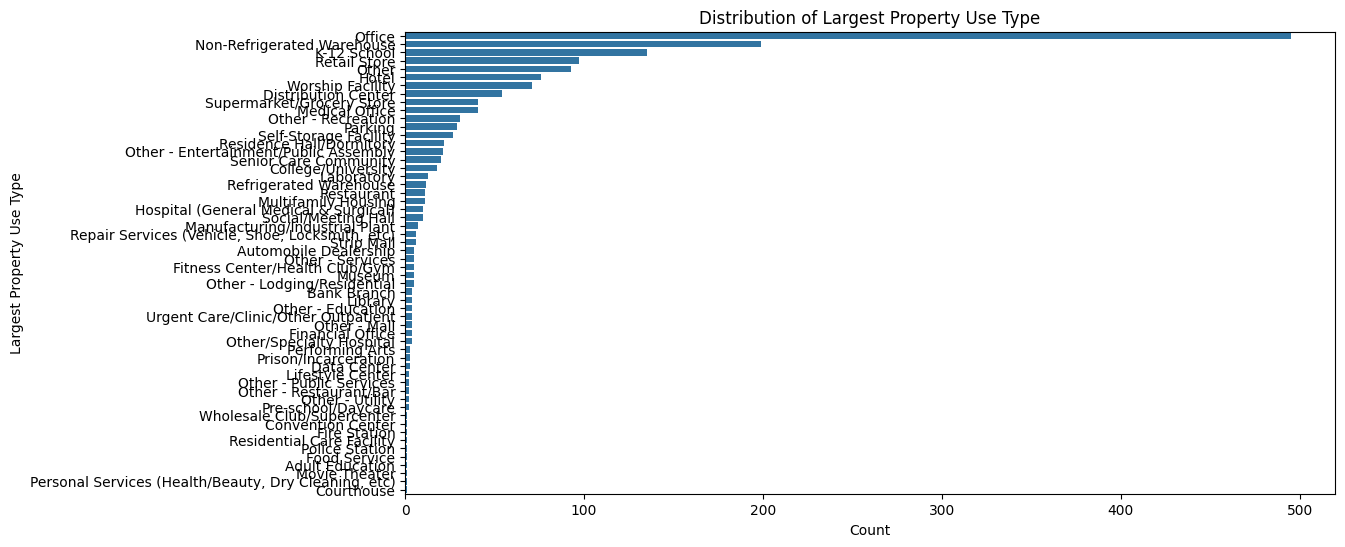

In [22]:
# Visualisation de la distribution de LargestPropertyUseType
plt.figure(figsize=(12,6))
sns.countplot(data=building_consumption, y='LargestPropertyUseType', order=building_consumption['LargestPropertyUseType'].value_counts().index)
plt.title('Distribution of Largest Property Use Type')
plt.xlabel('Count')
plt.ylabel('Largest Property Use Type')
plt.show()

In [25]:
# On crée une liste de potentielles features pour la modélisation
potential_features = ['LargestPropertyUseType']

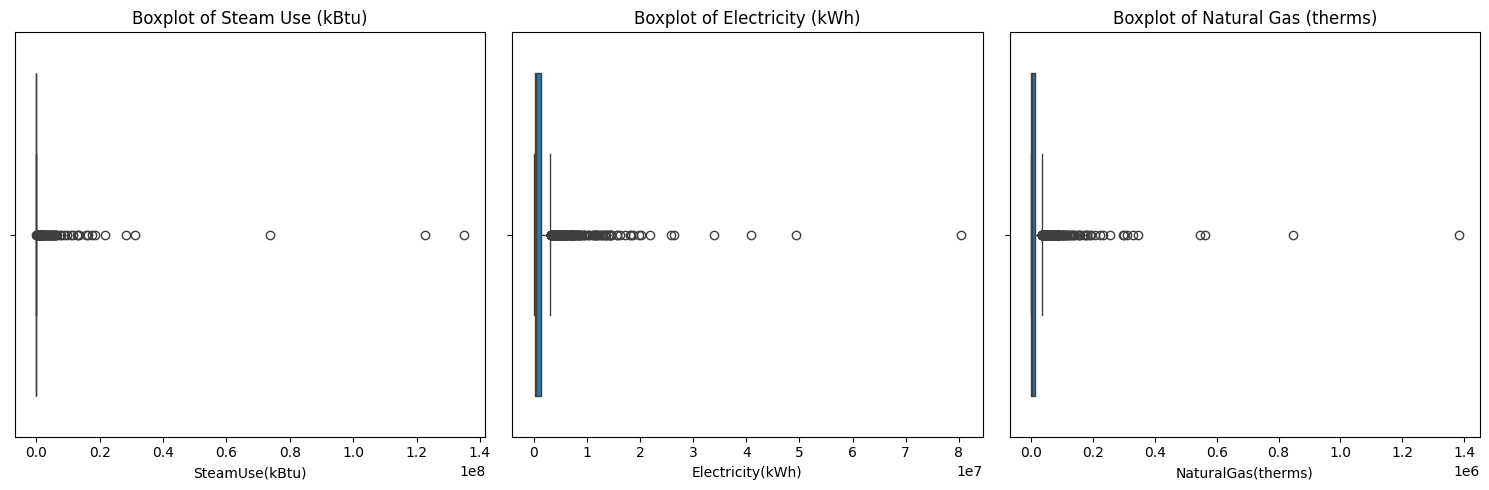

In [23]:
# On boxplot SteamUse(kBtu), Electricity(kWh), NaturalGas(therms)
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
sns.boxplot(x='SteamUse(kBtu)', data=building_consumption)
plt.title('Boxplot of Steam Use (kBtu)')
plt.subplot(1,3,2)
sns.boxplot(x='Electricity(kWh)', data=building_consumption)
plt.title('Boxplot of Electricity (kWh)')
plt.subplot(1,3,3)
sns.boxplot(x='NaturalGas(therms)', data=building_consumption)
plt.title('Boxplot of Natural Gas (therms)')
plt.tight_layout()
plt.show()

In [26]:
# On ajoute ces variables aux potentielles features et on supprime les valeurs manquantes
potential_features.extend(['SteamUse(kBtu)', 'Electricity(kWh)', 'NaturalGas(therms)'])
building_consumption = building_consumption.dropna(subset=potential_features)

In [27]:
building_consumption.shape

(1638, 46)

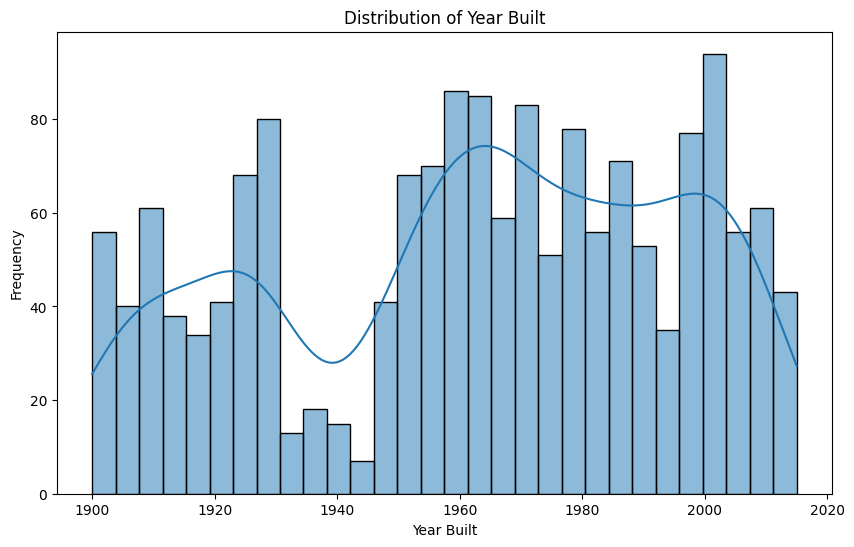

In [28]:
# Visualisation de la distribution de YearBuilt
plt.figure(figsize=(10,6))
sns.histplot(building_consumption['YearBuilt'], bins=30, kde=True)
plt.title('Distribution of Year Built')
plt.xlabel('Year Built')
plt.ylabel('Frequency')
plt.show()

In [29]:
potential_features.extend(['YearBuilt'])

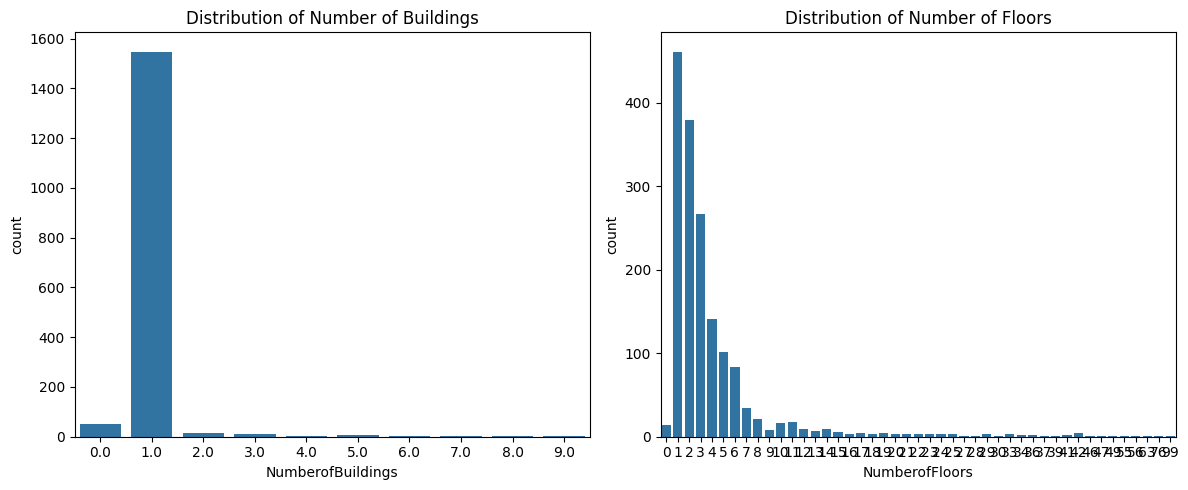

In [30]:
# Visualisation de NumberofBuildings et NumberofFloors
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x='NumberofBuildings', data=building_consumption)
plt.title('Distribution of Number of Buildings')
plt.subplot(1,2,2)
sns.countplot(x='NumberofFloors', data=building_consumption)
plt.title('Distribution of Number of Floors')
plt.tight_layout()
plt.show()

In [31]:
potential_features.extend(['NumberofBuildings', 'NumberofFloors'])

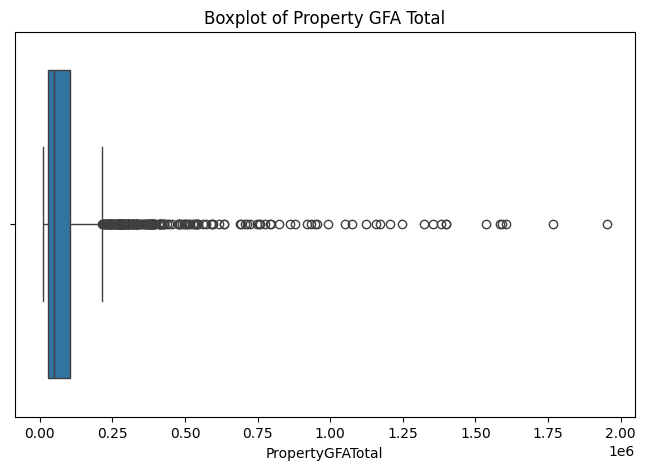

In [32]:
# Boxplot de PropertyGFATotal
plt.figure(figsize=(8,5))
sns.boxplot(x='PropertyGFATotal', data=building_consumption)
plt.title('Boxplot of Property GFA Total')
plt.show()

In [33]:
potential_features.extend(['PropertyGFATotal'])

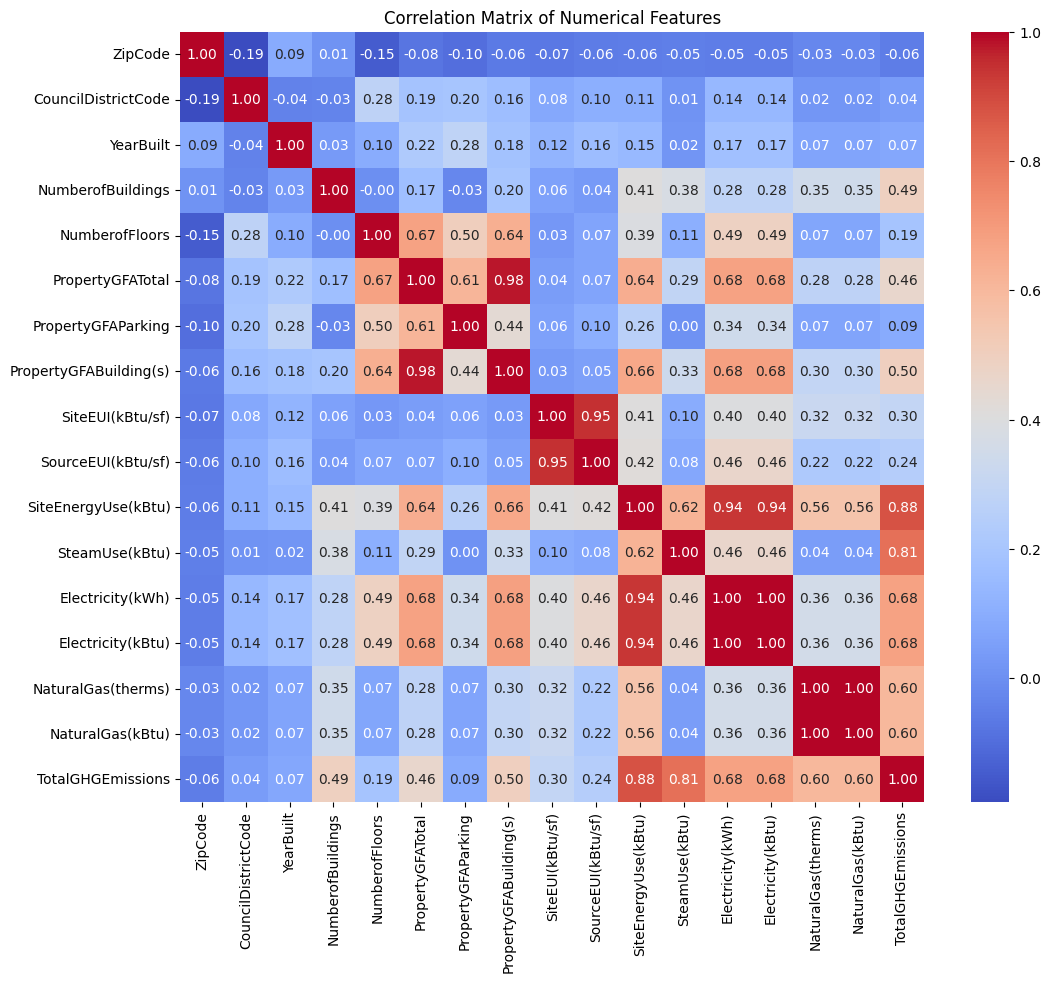

In [46]:
# On regarde la corrélation entre les variables numériques
numeric_cols = building_consumption.select_dtypes(include=['float64', 'int64']).columns
plt.figure(figsize=(12,10))
correlation_matrix = building_consumption[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

#### TERMINER L'ANALYSE EXPLORATOIRE 

A réaliser : 
- Une analyse descriptive des données, y compris une explication du sens des colonnes gardées, des arguments derrière la suppression de lignes ou de colonnes, des statistiques descriptives et des visualisations pertinentes.

# Modélisation 

### Import des modules 

In [ ]:
#Selection
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error 
from sklearn.inspection import permutation_importance

#Preprocess
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

#Modèles
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor


### Feature Engineering

A réaliser : Enrichir le jeu de données actuel avec de nouvelles features issues de celles existantes. 

In [ ]:
# CODE FEATURE ENGINEERING

### Préparation des features pour la modélisation

A réaliser :
* Si ce n'est pas déjà fait, supprimer toutes les colonnes peu pertinentes pour la modélisation.
* Tracer la distribution de la cible pour vous familiariser avec l'ordre de grandeur. En cas d'outliers, mettez en place une démarche pour les supprimer.
* Débarrassez-vous des features redondantes en utilisant une matrice de corrélation.
* Réalisez différents graphiques pour comprendre le lien entre vos features et la target (boxplots, scatterplots, pairplot si votre nombre de features numériques n'est pas très élevé).
*  Séparez votre jeu de données en un Pandas DataFrame X (ensemble de feautures) et Pandas Series y (votre target).
* Si vous avez des features catégorielles, il faut les encoder pour que votre modèle fonctionne.

In [ ]:
# CODE PREPARATION DES FEATURES

### Comparaison de différents modèles supervisés

A réaliser :
* Pour chaque algorithme que vous allez tester, vous devez :
    * Réaliser au préalable une séparation en jeu d'apprentissage et jeu de test via une validation croisée.
    * Si les features quantitatives que vous souhaitez utiliser ont des ordres de grandeur très différents les uns des autres, et que vous utilisez un algorithme de regression qui est sensible à cette différence, alors il faut réaliser un scaling (normalisation) de la donnée au préalable.
    * Entrainer le modèle sur le jeu de Train
    * Prédire la cible sur la donnée de test (nous appelons cette étape, l'inférence).
    * Calculer les métriques de performance R2, MAE et RMSE sur le jeu de train et de test.
    * Interpréter les résultats pour juger de la fiabilité de l'algorithme.
* Vous pouvez choisir par exemple de tester un modèle linéaire, un modèle à base d'arbres et un modèle de type SVM
* Déterminer le modèle le plus performant parmi ceux testés.

In [1]:
# CODE COMPARAISON DES MODELES

### Optimisation et interprétation du modèle

A réaliser :
* Reprennez le meilleur algorithme que vous avez sécurisé via l'étape précédente, et réalisez une GridSearch de petite taille sur au moins 3 hyperparamètres.
* Si le meilleur modèle fait partie de la famille des modèles à arbres (RandomForest, GradientBoosting) alors utilisez la fonctionnalité feature importance pour identifier les features les plus impactantes sur la performance du modèle. Sinon, utilisez la méthode Permutation Importance de sklearn. 

In [ ]:
# CODE OPTIMISATION ET INTERPRETATION DU MODELE